### Implementation

Necessary imports:

In [142]:
import sklearn.decomposition as dec
import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt


Function to preprocess data - cuting and mixing:

In [143]:
def mix_sound(sounds, mixture):
    mix_sound = np.zeros(sounds[0].shape[0])
    for i in range(len(mixture)):
        mix_sound += sounds[i]*mixture[i]
    return mix_sound
        


def preprocess_data(sounds, mixtures):
    min_length = float("inf")
    for sound in sounds:
        length = sound.shape[0]
        if length < min_length:
            min_length = length

    cut_sounds = []
    for sound in sounds:
        cut_sounds.append(sound[:min_length])

    mixed_sounds = []
    for i in range(len(sounds)):
        mixed_sounds.append(mix_sound(cut_sounds,mixtures[i]))
    return mixed_sounds

Functions to center and whiten the data:

In [144]:
def center_data(X):
    data = []
    for result in X:
        centered = result - np.mean(result)
        data.append(centered)
    return data

def whiten(X):
    covar_of_sig = np.cov(X)
    eig_val, eig_vec = np.linalg.eig(covar_of_sig)
    diag_eig = np.diag(eig_val)
    inv_sqr_of_diag = np.sqrt(np.linalg.pinv((diag_eig)))
    whiten_trans = np.dot(eig_vec, np.dot(inv_sqr_of_diag, eig_vec.T))
    whitened_sig = np.dot(whiten_trans, X)
    return whitened_sig

In [145]:
def f1(x):
	return 1/(1 + np.exp(-x))

def f1_der(x):
    d = f1(x)
    return d*(1 - d)

ICA function:

In [146]:
def ourICA(audio_sources, epsilon = 1e7):
    centered = center_data(audio_sources)
    sig_matrix = np.vstack(centered)
    whitened_signal_matr = whiten(sig_matrix)

    comps_of_V = []
    for i in range(whitened_signal_matr.shape[0]):
        num_of_sources = sig_matrix.shape[0]
        length_of_track = sig_matrix.shape[1]

        v1 = np.random.rand(num_of_sources)
        v1 = v1/np.linalg.norm(v1)
        v2 = np.random.rand(num_of_sources)
        v2 = v2/np.linalg.norm(v2)

        while( (1 - np.abs(np.dot(v1.T,v2))) > epsilon):
            v1 = v2
            first = np.dot(whitened_signal_matr, f1(np.dot(v2.T, whitened_signal_matr)))/length_of_track
            second = np.mean(f1_der(np.dot(v2.T, whitened_signal_matr)))*v2
            v2 = first - second
            v3 = v2
            for pres_comp in comps_of_V:
                v3 = v3 - np.dot(v2.T, pres_comp)*pres_comp
            v2 = v3
            v2 = v2/np.linalg.norm(v2)
        comps_of_V.append(v1)
    V = np.vstack(comps_of_V)
    S = np.dot(V, whitened_signal_matr)
    return S

### Application

Loading the data:

In [147]:
source1, sample_rate1 = librosa.load("./data/input_data/hello.mp3")
source2, sample_rate1 = librosa.load("./data/input_data/pespatron.mp3")
source3, sample_rate1 = librosa.load("./data/input_data/dunkel.mp3")
inputs = [source2, source1, source3]

Mixing sources:

In [148]:
mixed_sources = preprocess_data([source1, source2, source3], [[0.4, 0.3, 0.3], [0.3, 0.4, 0.3], [0.3, 0.3, 0.4]])

Unmixing using our implementation:

In [149]:
EPS = 1e-15 # epsilon, recommended over 1e-12
our_sources = ourICA(mixed_sources, epsilon=EPS)

Unmixing using in-built ICA function:

In [150]:
ica_performer = dec.FastICA(n_components = len(mixed_sources))
inbuilt_sources = ica_performer.fit_transform(list(zip(*mixed_sources))).T
inbuilt_sources = [inbuilt_sources[2], inbuilt_sources[1], inbuilt_sources[0]]

Write results into files:

In [151]:
for i in range(len(mixed_sources)):
    sf.write(f"./data/output_data/res{i}mixed.mp3", mixed_sources[i], sample_rate1)
for i in range(len(mixed_sources)):
    sf.write(f"./data/output_data/res{i}our.mp3", our_sources[i], sample_rate1)
for i in range(len(mixed_sources)):
    sf.write(f"./data/output_data/res{i}inbuilt.mp3", inbuilt_sources[i], sample_rate1)



In [ ]:
def timeDomainPlot(sample, sr):
  time = np.array(range(sample.shape[0])) / sr
  plt.plot(time, sample)
  plt.title('Time-domain representation')
  plt.xlabel('time, seconds')
  plt.show()


for mix in inbuilt_sources:
    timeDomainPlot(mix, sample_rate1)


In [67]:

def plotFFT(sample, sr, plot_len=8000):
  fft_res = np.fft.fft(sample)

  step = 1/sr

  freq = np.fft.fftfreq(len(sample), step)
  amplitude = np.abs(fft_res)

  plt.figure(figsize=(15, 5))
  plt.plot(freq, amplitude)

  plt.xlabel('Freq (Hz)')
  plt.xlim(0, plot_len)
  plt.show()


In [130]:
#inbuilt_sources = [inbuilt_sources[0], inbuilt_sources[2], inbuilt_sources[1]]
#inputs = [inputs[0], inputs[2], inputs[1]]
#results = [our_sources, inputs, inbuilt_sources]

Song 1:


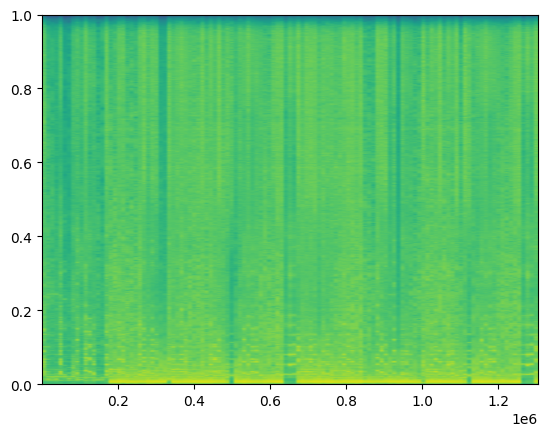

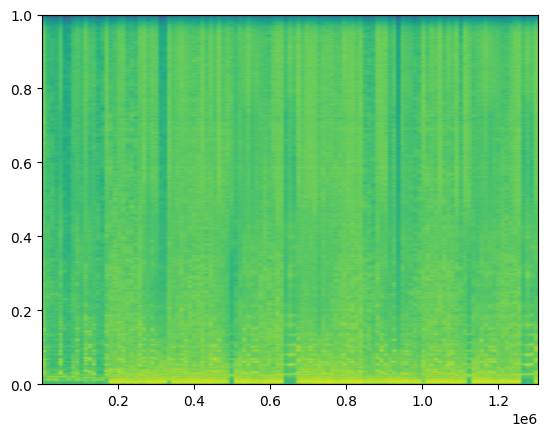

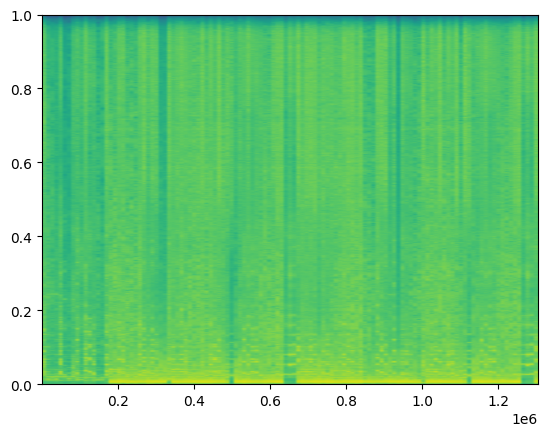

Song 2:


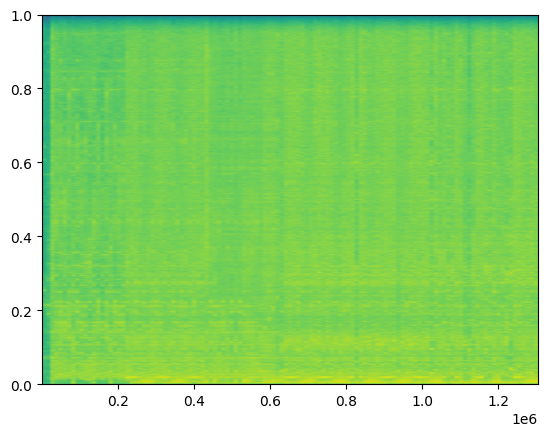

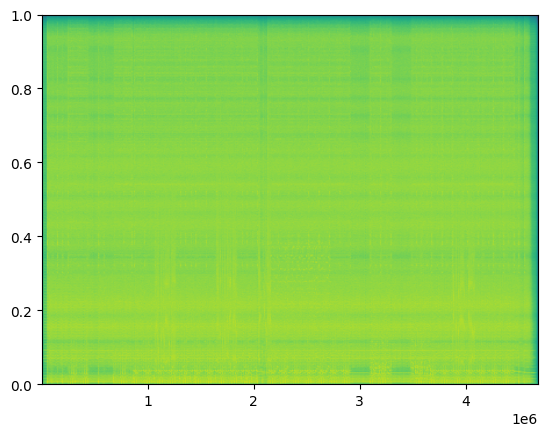

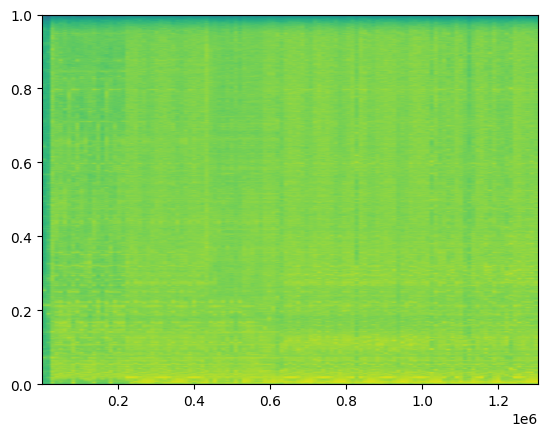

Song 3:


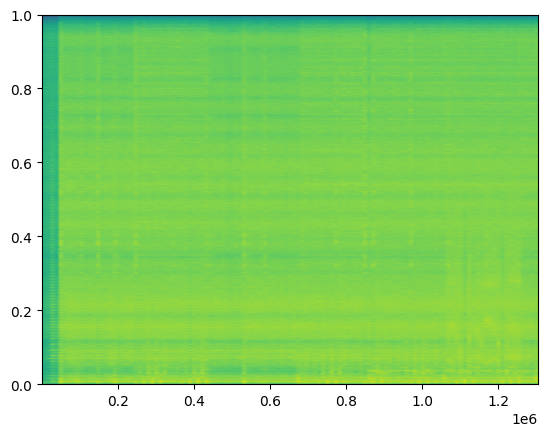

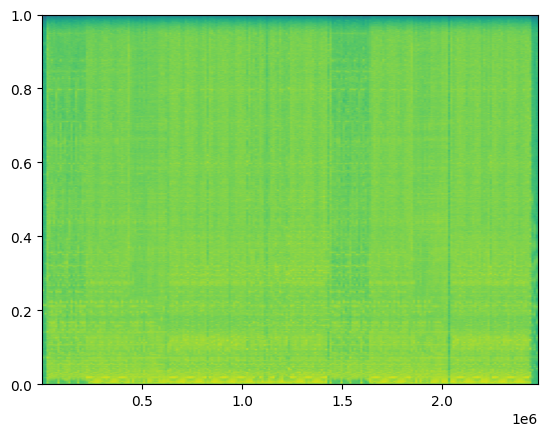

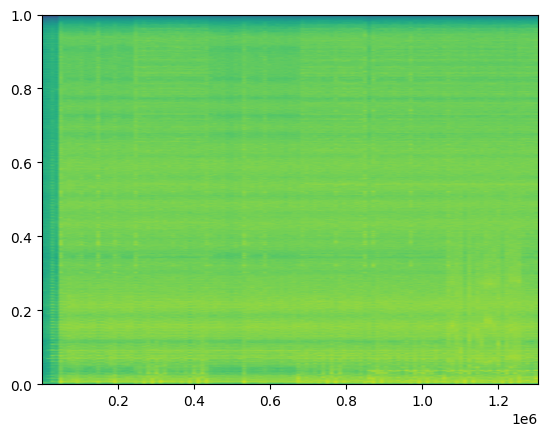

In [141]:

for i in range(3):
    print(f'Song {i+1}:')
    for arr in results:
        plt.specgram(arr[i], sample_rate1)
        plt.show()

Song 1:


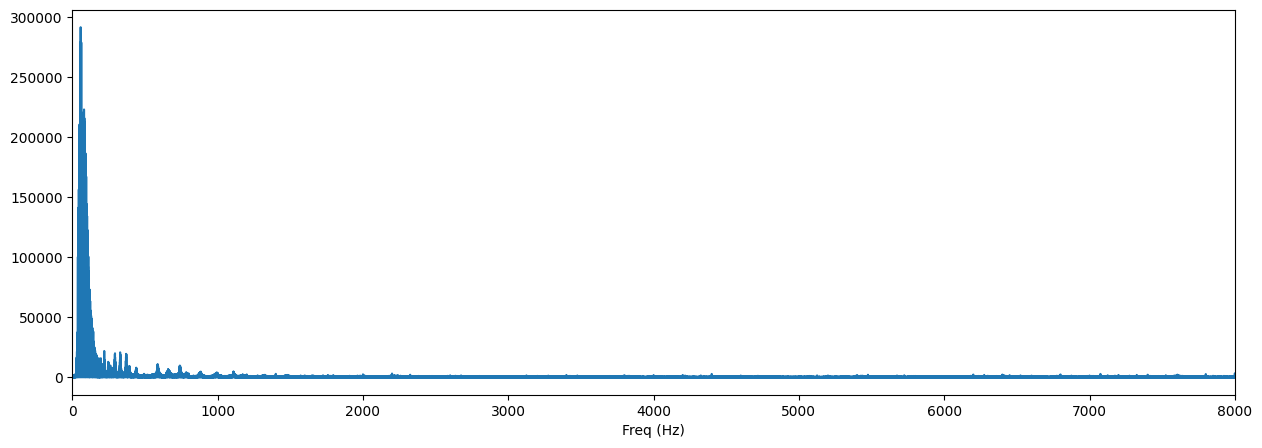

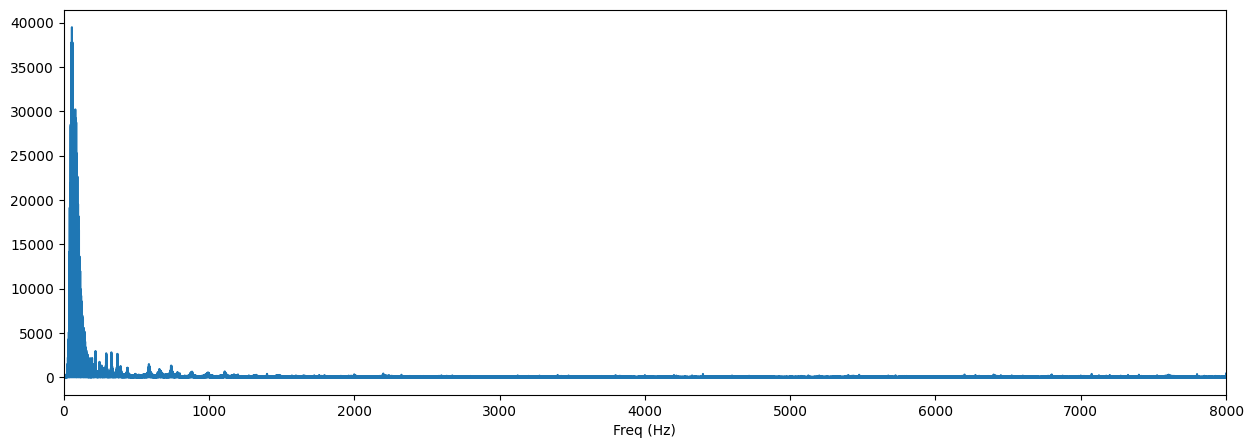

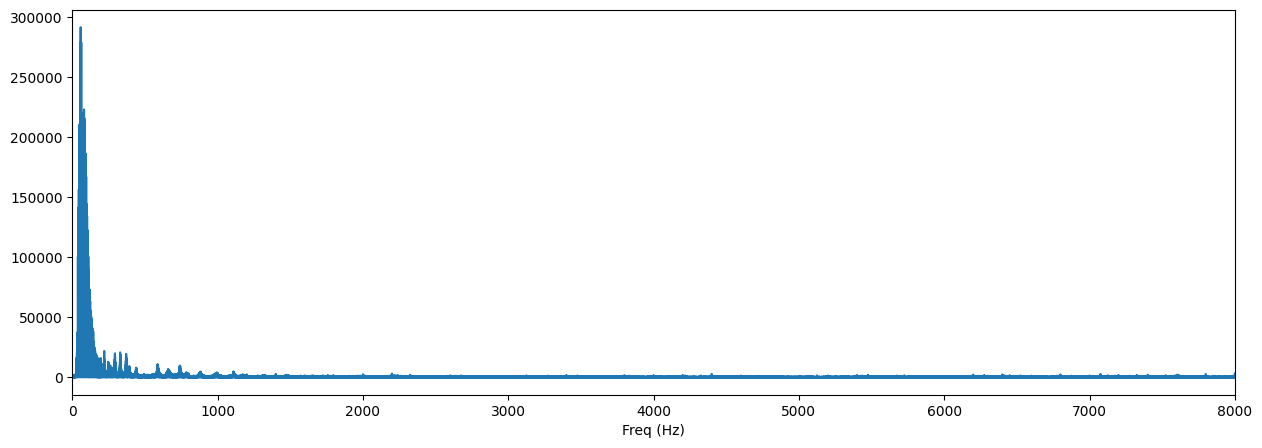

Song 2:


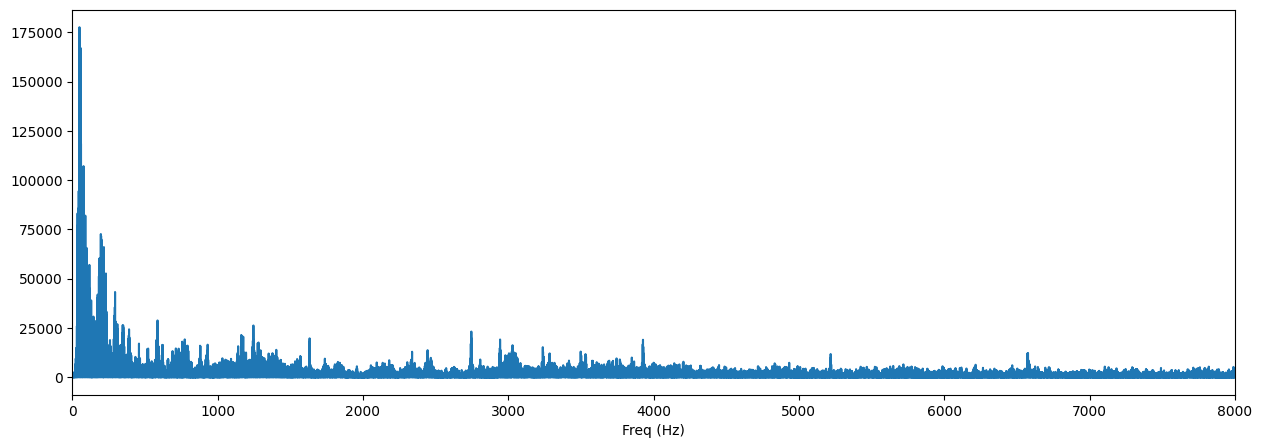

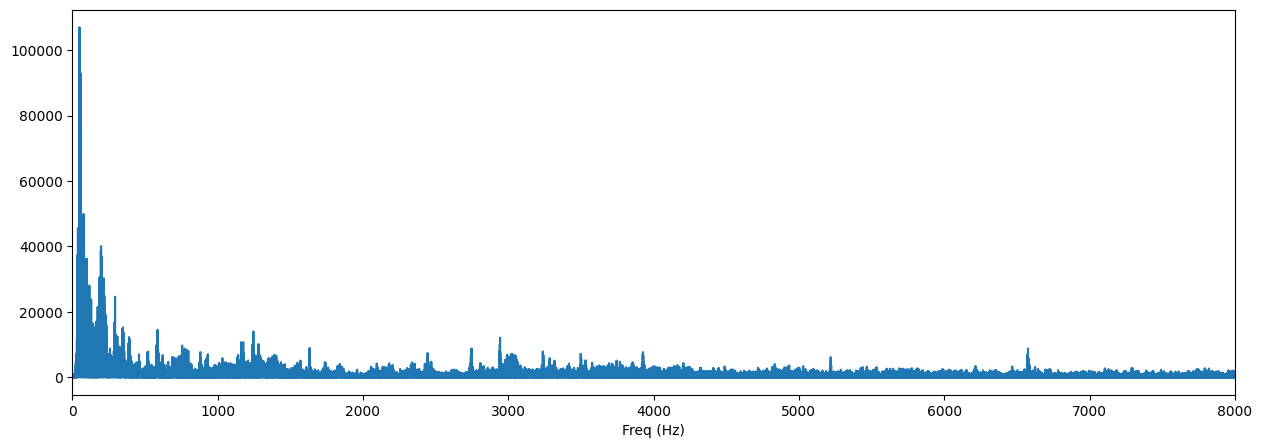

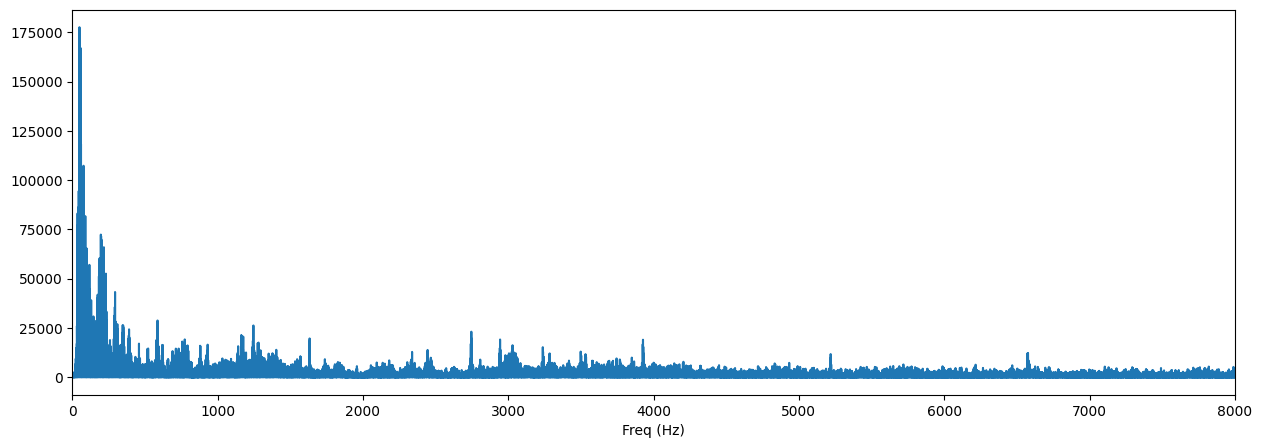

Song 3:


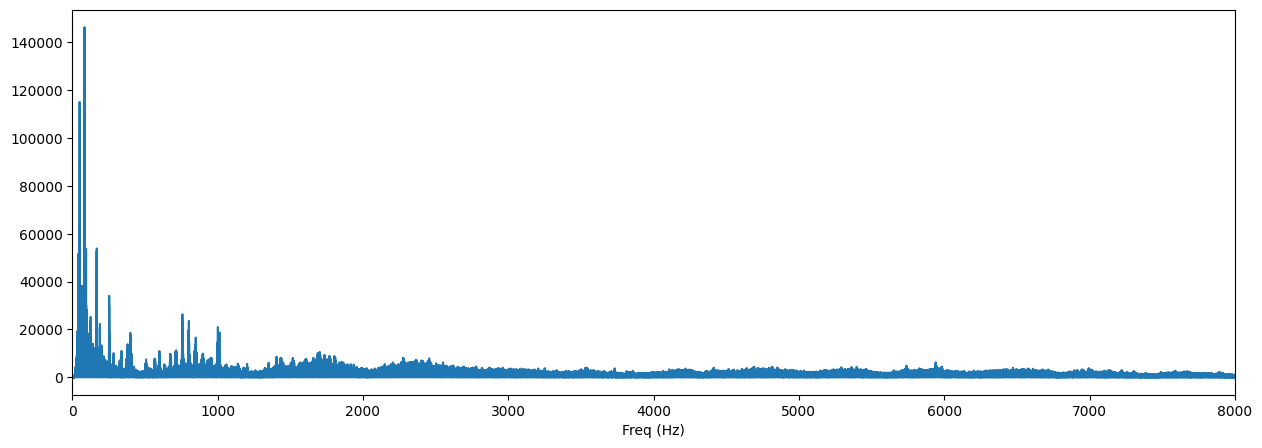

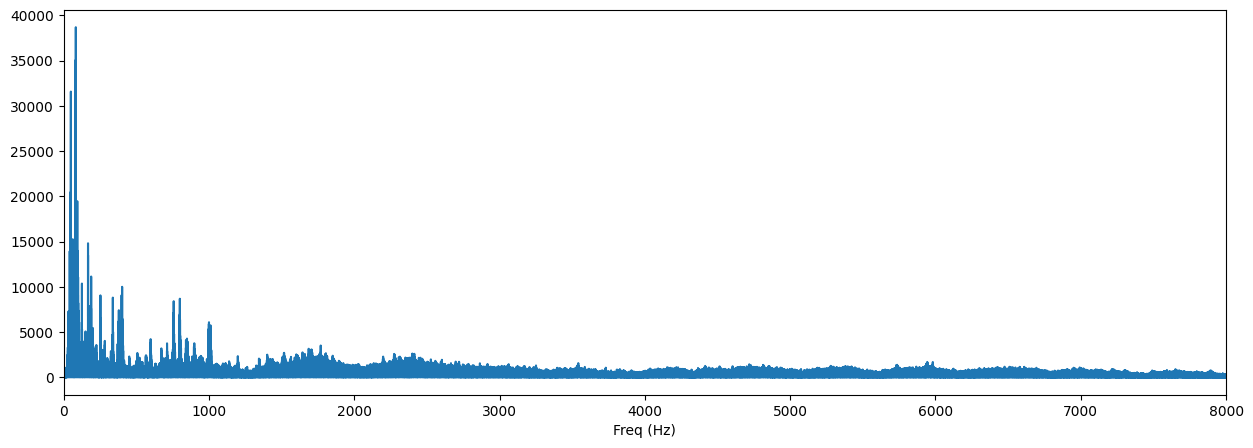

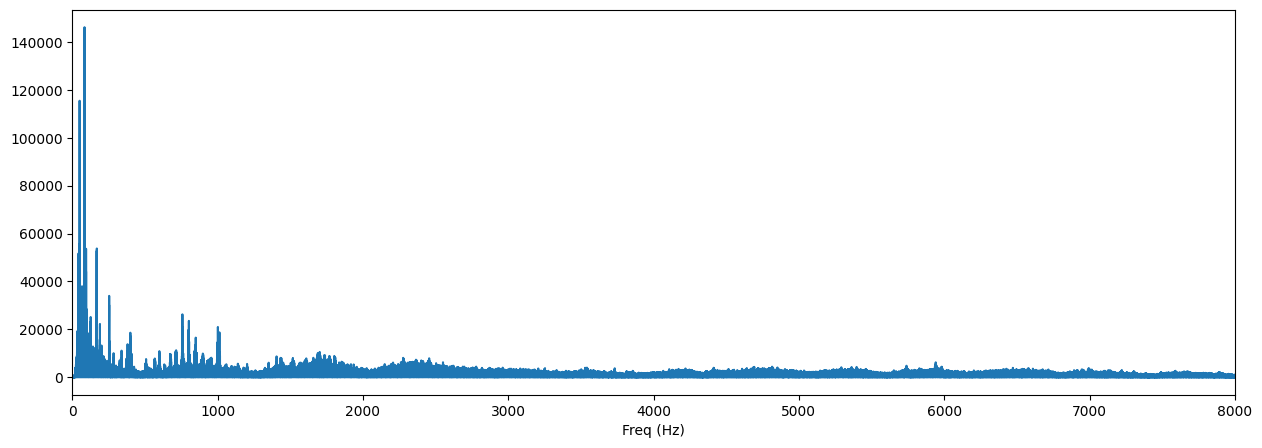

In [131]:
for i in range(3):
  print(f'Song {i+1}:')
  for arr in results:
      plotFFT(arr[i], sample_rate1)